## History of "literature" - Page-level co-occurrence in Hathi Trust

So, to pick up where we left off last time. Over the course of the last two weeks, I've blocked in the code to do the basic page-level co-occurrence analysis, which turned out to be a bit more complex than I thought - though in some really interesting ways. After getting the overall counts for each token in each year (the "baseline" counts that I showed before), the next step was to extract a second, filtered set of counts that would record the number of times each word appeared on pages that contain "literature." Put together, these two sets of counts give us the building blocks that we need to track the diachronic change in a word's association with literature - find words that have a particularly volatile / dynamic / "trending" relationship with literature over time.

We're now storing two different types of counts in two tables:

```sql
CREATE TABLE count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year)
);
CREATE TABLE anchored_count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	anchor_count INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year, anchor_count)
);
```

The `count` table stores the overall, unfiltered counts for words on all pages, broken out by year. Eg:

**`"literature" / 1900 / 89608`**

Meaning, "literature" appears 89,608 times in 1900. Meanwhile, `anchored_count` stores counts just for words that appear on pages that contain literature, broken out by the year and by the number of times that "literature" itself appears on the page in question. (This will allow us to dig into the question of whether there's a difference between pages that are really _about_ literature, as opposed to pages that just use the word in passing.) Eg:

**`"poetry" / 1900 / 4 / 5967`**

Meaning - in 1900, "poetry" appears 5,967 times on pages where "literature" appears 4 times. In total, the extraction run chewed through all ~820k volumes in the Harvard collection in Hathi Trust, and observed a total of **43.5 billion** tokens:

In [1]:
from hol.models import Count, AnchoredCount

print(Count.total_token_count())

43401065888


Which is still only about 1/5 of the whole collection. It turns out, the Harvard collection is basically a C19 corpus. Here's the overall volume trend:

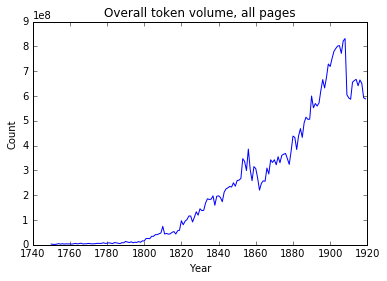

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

years = range(1750, 1920)

series = Count.year_count_series(years)

plt.title('Overall token volume, all pages')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

## The metric - log-likelihoods, ranked and scaled

So, two sets of counts - one for all pages, and the other just for pages that contain "literature." Even though both are drawn from the same corpus, we can think of them as representing two separate corpora - the corpus of "literature" pages, and the corpus of all pages, a sub-corpus and a super-corpus. What we want, is - which words appear in the literature corpus at a higher-than-expected rate, when compared against the overall frequencies in the super-corpus?

There are a couple of ways to go about this - a log-likelihood tests, the Mann-Whitney ranks tests, and others. The log-likelihood is the most canonical and straightforward, though, so let's start with that. To measure the distinctiveness of "great" in 1900, we need 4 pieces of information:

In [3]:
a = AnchoredCount.token_year_count('great', 1900)
print('The number of times "great" appears on pages that contain "literature" > 5 times:')
print(a, '\n')

b = Count.token_year_count('great', 1900)
print('The number of times "great" appears on all pages:')
print(b, '\n')

c = AnchoredCount.year_count(1900)
print('The total number of tokens observed on pages that contain "literature" > 5 times:')
print(c, '\n')

d = Count.year_count(1900)
print('Total number of tokens observed on all pages:')
print(d)

The number of times "great" appears on pages that contain "literature" > 5 times:
41986 

The number of times "great" appears on all pages:
925673 

The total number of tokens observed on pages that contain "literature" > 5 times:
23646454 

Total number of tokens observed on all pages:
719028426


Then, we can use scipy's `chi2_contingency` function to calculate the log-likelihood:

In [4]:
import numpy as np

from scipy.stats import chi2_contingency

g, p, dof, exp = chi2_contingency(
    np.array([[a, b], [c, d]]),
    lambda_='log-likelihood',
)

print(g)

3765.27132696


This is expensive to compute for an individual word, but it can be sped up by querying big batches of counts and calculating the scores in bulk. These get shoveled into a `score` table, which stores the token, year, log-likelihood ("score"), and a derived "rank" metric, which we'll look at in a moment:

```sql
CREATE TABLE score (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	score FLOAT NOT NULL, 
	PRIMARY KEY (token, year)
);
```

So, once we've filled in this table with log-likelihood scores for each token in each year, we can generate a list of the words in a given year that are most associated with literature. Here's the list for 1900, pulling from pages that contain literature more than 5 times:

In [5]:
import pprint

from collections import OrderedDict
from hol.models import Score

topn = Score.topn_by_year(1900, 50)

scores = OrderedDict()
for token, (score, rank) in topn.items():
    scores[token] = score
    
pp = pprint.PrettyPrinter()
pp.pprint(scores)

OrderedDict([('english', 5995.673107665032),
             ('literary', 3820.5985417596894),
             ('history', 3705.8351214244103),
             ('professor', 3239.294100448038),
             ('language', 2290.153895401676),
             ('books', 2001.668119215872),
             ('american', 1687.7482990107574),
             ('book', 1642.570412227638),
             ('poetry', 1507.4949554457794),
             ('university', 1459.2288094651908),
             ('study', 1341.981826871721),
             ('prose', 1308.1927198202545),
             ('writers', 1282.4655070881258),
             ('authors', 1250.9792908355407),
             ('century', 1201.2861031609016),
             ('languages', 1110.6825168783676),
             ('of', 1026.6466562692985),
             ('german', 996.5862329926136),
             ('latin', 976.1989634215894),
             ('library', 963.2981365407198),
             ('reading', 894.3778861350803),
             ('was', 881.3246952594754),
           

Looks sensible, with a couple curiosities ("of"?), which I'll get into later. So now, with this, the next step is to pull these stats for each year, and string together time-series signals for each word to get a diachronic progression of it's stickiness with literature. But, out-of-the-box, this doesn't work. The problem is that the log-likelihood scores can be used to compare words within an individual year, but not _across_ years, because the values are boosted by the overall volumes of the tokens. This is actually a feature of the log-likelihood, not a bug - when scoring a word, it rewards tokens that both (a) have a higher-than-expected frequency in the analysis corpus and (b) have a high overall frequency. This is important, because otherwise the top of the list would be swamped by very infrequent words that - for instance - were expected to appear 1 time but actualy appeared 5 times. If you just compare the values directly, this comes out to a 500% increase over the expected. But, since the numbers are so small, this could just be a fluke - a single page out of millions. The intuition behind log-likelihood is that we care much more about a word that's expected to appear 1,000 times but actually occurs 1,200. Just a 20% increase, but we can say with much more confidence that the difference is meaningful.

So, log-likelihood is great for ranking words inside of a single year, but it means that if we string together the raw scores into time series, we end up just proxying the overall volume trend. For example, here's the log-likelihood series for "great":

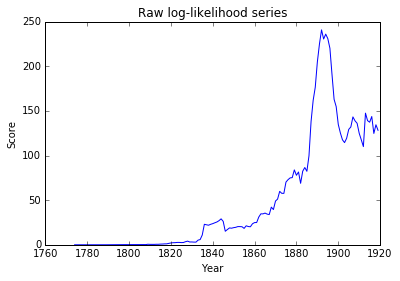

In [6]:
years = range(1750, 1920)

series = Score.score_series_smooth('great', years)

plt.title('Raw log-likelihood series')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*series.items()))

But compare this to the baseline frequency trend for "great":

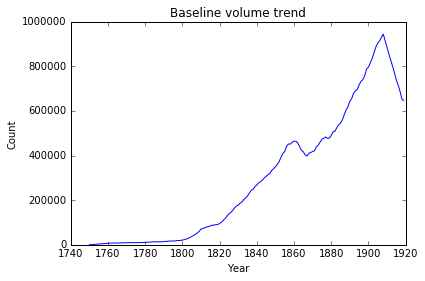

In [7]:
years = range(1750, 1920)

series = Count.token_count_series_smooth('great', years)

plt.title('Baseline volume trend')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))

Both increase fairly monotonically, then fall off near the end of the 19th century. There's clearly some difference here - the log-likelihood peaks earlier? - but it's fairly subtle and would be hard to tease out computationally. What we really want, though, is a way to normalize the magnitudes of the log-likelihoods, similar to the words-per-million scaling that we use on the overall frequencies. This is an interesting problem. At first, I tried just scaling everything down to "unit variance" - sliding and squishing the scores so that they center around 0 and have a variance of 1. But, when I plotted the transformed scores, the trend lines looked basically unchanged - still basically just a proxy for volume.

This doesn't work, I think, because _the total number of unique word forms in a year increases along with the overall volume_. In other words, if there are 1,000 total tokens in 1800 and 100 unique word forms, then in 1900 there might be 10,000 total tokens but _1,000_ unique words, not just more occurrences of the same set of 100. Most of these new words will be un-correlated with "literature," which has the effect of packing in lots of low-correlation words right around the mean at 0. Which, in turn, allows the high-magnitude outliers to creep further and further away from 0 over time - shadowing the volume increase - even while holding the variance at 1.

To fix this, I first tried this:

1. Take the rank-order of the log-likelihood scores. Eg, for N scores - the lowest score gets a rank of 1 the highest a rank of N.

1. Project the ranks down to a 0-1 scale.

The idea is to capture a word's _position_ on the "depth chart" for the year, with 0 at the bottom and 1 at the top. So, we get this for 1900 - same rank order, but now with the normalized scores:

In [11]:
topn = Score.topn_by_year(1900, 50)

scores = OrderedDict()
for token, (score, rank) in topn.items():
    scores[token] = rank
    
pp = pprint.PrettyPrinter()
pp.pprint(scores)

OrderedDict([('english', 0.9999999999999999),
             ('literary', 0.9998570407433881),
             ('history', 0.9997140814867762),
             ('professor', 0.9995711222301643),
             ('language', 0.9994281629735524),
             ('books', 0.9992852037169406),
             ('american', 0.9991422444603287),
             ('book', 0.9989992852037168),
             ('poetry', 0.998856325947105),
             ('university', 0.9987133666904932),
             ('study', 0.9985704074338813),
             ('prose', 0.9984274481772694),
             ('writers', 0.9982844889206576),
             ('authors', 0.9981415296640457),
             ('century', 0.9979985704074338),
             ('languages', 0.9978556111508219),
             ('of', 0.9977126518942101),
             ('german', 0.9975696926375982),
             ('latin', 0.9974267333809863),
             ('library', 0.9972837741243745),
             ('reading', 0.9971408148677626),
             ('was', 0.9969978556111507),
 

And now, when we plot the time-series progressions for these values, we can start to get some real interpretive purchase on the question at hand. Here's the normalized signal for "great" from 1750 - 1920:

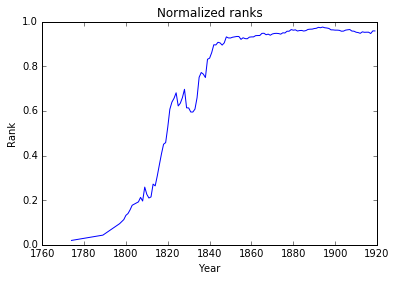

In [9]:
years = range(1750, 1920)

series = Score.rank_series_smooth('great', years)

plt.title('Normalized ranks')
plt.xlabel('Year')
plt.ylabel('Rank')
plt.plot(*zip(*series.items()))

Ah! So, "great" is basically un-correlated with "literature" at the beginning of the 19th century, but then rapidly climps up to the top of the list and stays there from ~1840 on. (The dip at the end is a smoothing artifact.) Even while the relative frequency of "great" monotonically decreases over the same period:

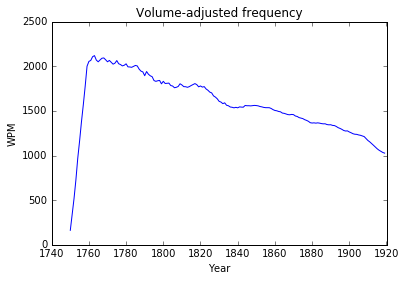

In [10]:
years = range(1750, 1920)

series = Count.token_wpm_series_smooth('great', years)

plt.title('Volume-adjusted frequency')
plt.xlabel('Year')
plt.ylabel('WPM')
plt.plot(*zip(*series.items()))

This looks like good evidence that we're picking up on a signal for "stickiness" with literature that's independent of the baseline frequency trend.

## Finding "volatile" signals

So, given the huge sea of words in the database - how to we find words that have potentially intersting relationships with literature? There are lots of ways to go about this, I think. To start, though, let's do this - just take the raw variance of the values in the signal, which will pick out words that have both very high and very low values over the coures of the 19th century - words with high "acceleration" to and from literature.

Take a look at the appendix for a complete list of the top 200 words, ranked in this way. A couple of observations:

**TODO**